# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.10.0
# sklearn 0.24.2

## Setup

In [2]:
fit_SQ = 0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat

import tensorflow as tf

from lmfit import Minimizer, Parameters, create_params, report_fit
print(tf. __version__)

2.10.0


## Load data

In [4]:
W = 10

In [5]:
import os
data_path = './fwdexternalsilica/'
filename_0 = '{}_600.dat'.format(W)
filename_1 = '{}_1100.dat'.format(W)
print(filename_0)
data_0 = np.genfromtxt(data_path + filename_0, skip_header=39, delimiter=[11,15,12,10])
data_1 = np.genfromtxt(data_path + filename_1, skip_header=39, delimiter=[11,15,12,10])
data_p = np.genfromtxt(data_path + '168606_d01_c01.dat', skip_header=39, delimiter=[11,14,11,10])

10_600.dat


In [6]:
Q_0 = data_0[:,0]
IQ_data_0 = data_0[:,1]
IQ_er_0 = data_0[:,2]
dQ_0 = data_0[:,3]

Q_1 = data_1[:,0]
IQ_data_1 = data_1[:,1]
IQ_er_1 = data_1[:,2]
dQ_1 = data_1[:,3]

Q_p = data_p[:,0]
IQ_data_p = data_p[:,1]
IQ_er_p = data_p[:,2]
dQ_p = data_p[:,3]

In [7]:
# load desmeared data
filename_0 = '{}_600_d.txt'.format(W)
filename_1 = '{}_1100_d.txt'.format(W)
filename_p = 'dilute.txt'
print(filename_0)

data_0 = np.genfromtxt(data_path + filename_0, skip_header=0, delimiter=[16,16,16])
data_1 = np.genfromtxt(data_path + filename_1, skip_header=0, delimiter=[16,16,16])
data_p = np.genfromtxt(data_path + filename_p, skip_header=0, delimiter=[16,16,16])

Q_0_d = data_0[:,0]
IQ_data_0_d = data_0[:,1]
IQ_er_0_d = data_0[:,2]

Q_1_d = data_1[:,0]
IQ_data_1_d = data_1[:,1]
IQ_er_1_d = data_1[:,2]

Q_p_d = data_p[:,0]
IQ_data_p_d = data_p[:,1]
IQ_er_p_d = data_p[:,2]

10_600_d.txt


Fit P(Q) to obtain the HS diameter

In [8]:
# fit P(Q)
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def fuzzysphere(q,sigma=1,sigma_f=0.1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2*np.exp(-(sigma_f*sigma*q)**2/2)
    return P

def log_normal_pdf(mu,sigma,x):
    return np.exp(-(np.log(x)-mu)**2/2/sigma**2)/x/sigma

def P_HS_eff(q,sigma=1,d_sigma=0.05):
    n_sample = 141
    sigma_list = (1+np.linspace(-7,7,n_sample)*d_sigma)*sigma
    # p_sigma = np.exp(np.linspace(-3,3,n_sample)**2/2)*(sigma_list)**6
    p_sigma = log_normal_pdf(0,d_sigma,sigma_list/sigma)*(sigma_list)**6
    # var = d_sigma**2
    # k = 1/var
    # x = (1+np.linspace(-3,3,n_sample)*d_sigma)
    # p_sigma = k**k*x**(k-1)*np.exp(-k*x)/gamma(k)

    P_eff = np.zeros_like(q)

    for i in range(n_sample):
        P_i = hardsphere(q,sigma_list[i])*p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff/np.sum(p_sigma)

    return P_eff

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out # sampled on Q

def I_P(Q, sigma, A, I_inc, d_sigma):
    P = P_HS_eff(Q_p,sigma=sigma,d_sigma=d_sigma)
    Q_fine = Q_p
    P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    P = f_interp(Q)

    return A*P + I_inc

def I_P_d(Q, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    # Q_fine = Q
    # P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    # f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    # P = f_interp(Q)

    return A*P + I_inc

In [9]:
params = Parameters()
params.add('sigma', value=1200, min=1100, max=1300)
params.add('A', value=2.2e3, min=2e3, max=2.5e3)
params.add('I_inc', value=1.5, min=1, max=2)
params.add('d_sigma', value=0.025, min=0.01, max=0.15)

index_Q = (Q_p_d>1e-3)*(Q_p_d<2e-1)
# loss function for fitting form factor
def lambda_P(params, Q, data, index_Q):
    v = params.valuesdict()
    return (np.log(I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])) - np.log(data))[index_Q]

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_P, params, fcn_args=(Q_p_d, IQ_data_p_d, index_Q))
result_P = minner.minimize()

# fitted curve
IQ_fit = np.exp(np.log(IQ_data_p_d)[index_Q] + result_P.residual)

# write error report
report_fit(result_P)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 164
    # variables        = 4
    chi-square         = 4.21572478
    reduced chi-square = 0.02634828
    Akaike info crit   = -592.411363
    Bayesian info crit = -580.011898
[[Variables]]
    sigma:    1191.90086 +/- 4.55077611 (0.38%) (init = 1200)
    A:        2477.09578 +/- 72.1151655 (2.91%) (init = 2200)
    I_inc:    1.15648492 +/- 0.01885715 (1.63%) (init = 1.5)
    d_sigma:  0.06156041 +/- 0.00349277 (5.67%) (init = 0.025)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, A)       = +0.4923
    C(sigma, d_sigma) = -0.2580
    C(A, I_inc)       = -0.1287
    C(A, d_sigma)     = -0.1081


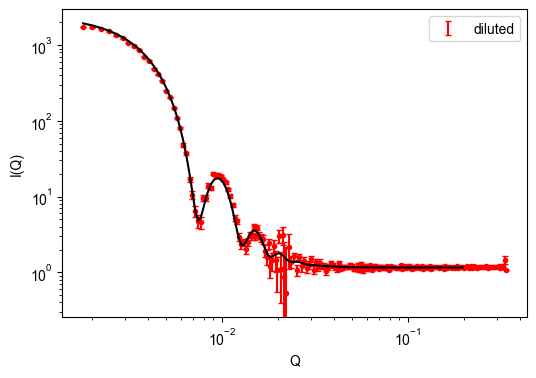

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_p_d,IQ_data_p_d,'.r')
ax.errorbar(Q_p_d,IQ_data_p_d,IQ_er_p_d,linestyle='',label='diluted',color='r',capsize=2)
# ax.plot(Q_p,IQ_data_p,'.m',label='diluted')
ax.plot(Q_p_d[index_Q],IQ_fit,'-k',zorder=3)
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

Fit I(Q) to obtain the intensity

In [11]:
# loss function for fitting form factor
def lambda_I(params, Q, data, index_Q):
    v = params.valuesdict()
    return (np.log(I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)) 
          - np.log(data))[index_Q]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 162
    # variables        = 2
    chi-square         = 1.40129390
    reduced chi-square = 0.00875809
    Akaike info crit   = -765.532450
    Bayesian info crit = -759.357258
[[Variables]]
    A:      30979.1430 +/- 543.975696 (1.76%) (init = 50000)
    I_inc:  0.90767451 +/- 0.00809956 (0.89%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, I_inc) = -0.1695


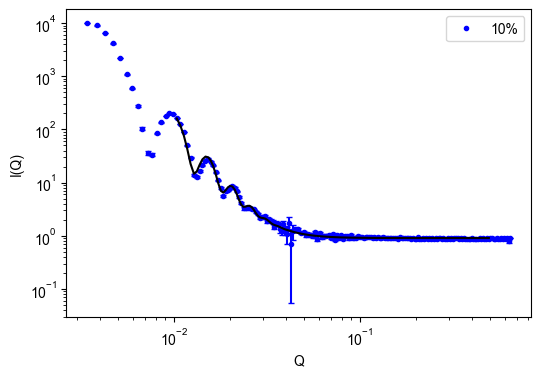

In [12]:
sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=5e4, min=2e4, max=6e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q_0_d>1e-2)*(Q_0_d<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q_0_d, IQ_data_0_d, index_Q))
result_I_0 = minner.minimize()

# fitted curve
IQ_fit = np.exp(np.log(IQ_data_0_d)[index_Q] + result_I_0.residual)

# write error report
report_fit(result_I_0)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_0_d,IQ_data_0_d,'.b',label='{}%'.format(W))
ax.errorbar(Q_0_d,IQ_data_0_d,IQ_er_0_d,linestyle='',color='b',capsize=2)
ax.plot(Q_0_d[index_Q],IQ_fit,'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 159
    # variables        = 2
    chi-square         = 1.60489060
    reduced chi-square = 0.01022223
    Akaike info crit   = -726.739929
    Bayesian info crit = -720.602120
[[Variables]]
    A:      42633.9819 +/- 729.135597 (1.71%) (init = 40000)
    I_inc:  1.38943991 +/- 0.01400371 (1.01%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, I_inc) = -0.1622


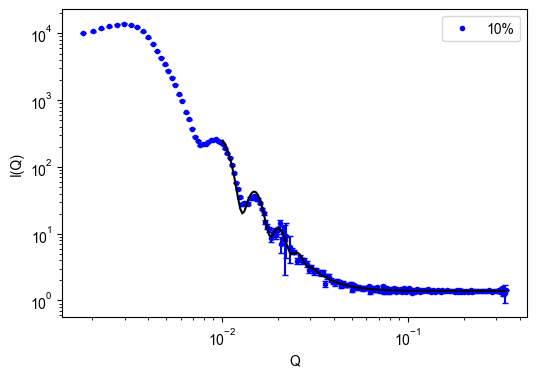

In [13]:
sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=4e4, min=2e4, max=6e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q_1_d>1e-2)*(Q_1_d<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q_1_d, IQ_data_1_d, index_Q))
result_I_1 = minner.minimize()

# fitted curve
IQ_fit = np.exp(np.log(IQ_data_1_d)[index_Q] + result_I_1.residual)

# write error report
report_fit(result_I_1)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_1_d,IQ_data_1_d,'.b',label='{}%'.format(W))
ax.errorbar(Q_1_d,IQ_data_1_d,IQ_er_1_d,linestyle='',color='b',capsize=2)
ax.plot(Q_1_d[index_Q],IQ_fit,'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

In [14]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I_0 = result_I_0.params.valuesdict()
fp_opt_I_1 = result_I_1.params.valuesdict()

### Joining the curves


In [15]:
# IQ_0 = (IQ_data_0_d-fp_opt_I_0[1])/fp_opt_I_0[0]
# IQ_1 = (IQ_data_1_d-fp_opt_I_1[1])/fp_opt_I_1[0]
# IQ_er_0 = (IQ_er_0_d)/fp_opt_I_0[0]
# IQ_er_1 = (IQ_er_1_d)/fp_opt_I_1[0]

# Q_scan_list = np.linspace(1e-3,2e-1,1000)
# Q_scan = []
# IQ_scan = []
# i_Qc_0 = 0
# i_Qc_1 = 0
# for Q in Q_scan_list:
#     update_0=0
#     update_1=0
#     if Q>Q_0_d[i_Qc_0]:
#         i_Qc_0 += 1
#         update_0=1
#     if Q>Q_1_d[i_Qc_1]:
#         i_Qc_1 += 1
#         update_1=1
#     if update_0+update_1==0:
#         continue

#     IQc_0 = IQ_0[i_Qc_0]
#     IQc_1 = IQ_1[i_Qc_1]

#     i_smaller = 0
#     if IQc_1<IQc_0:
#         i_smaller = 1

#     Qc = [Q_0_d[i_Qc_0],Q_1_d[i_Qc_1]]
#     IQc = [IQc_0,IQc_1]

#     Q_scan.append(Qc[i_smaller])
#     IQ_scan.append(IQc[i_smaller])

# Q_scan = np.array(Q_scan)
# IQ_scan = np.array(IQ_scan)

C:\Users\wagen\AppData\Local\Temp\ipykernel_53844\243443905.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,0.04])


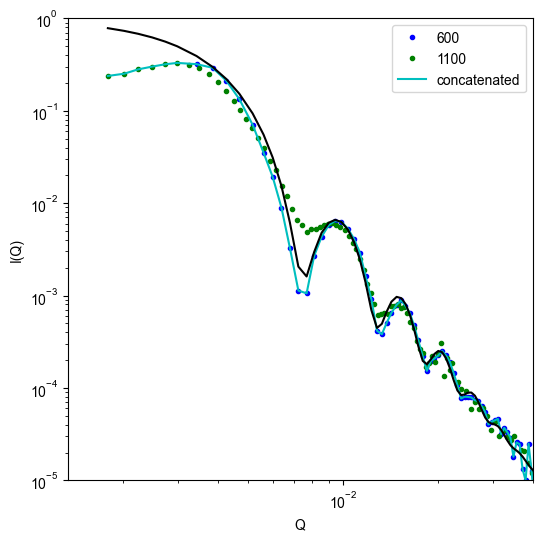

In [16]:
IQ_0 = (IQ_data_0_d-fp_opt_I_0['I_inc'])/fp_opt_I_0['A']
IQ_1 = (IQ_data_1_d-fp_opt_I_1['I_inc'])/fp_opt_I_1['A']
IQ_er_0 = (IQ_er_0_d)/fp_opt_I_0['A']
IQ_er_1 = (IQ_er_1_d)/fp_opt_I_1['A']

Q_switch = 3e-3
index_cat_0 = Q_0_d>Q_switch
index_cat_1 = Q_1_d<Q_switch
Q_cat_0 = Q_0_d[index_cat_0]
Q_cat_1 = Q_1_d[index_cat_1]
IQ_cat_0 = IQ_0[index_cat_0]
IQ_cat_1 = IQ_1[index_cat_1]
IQ_er_cat_0 = IQ_er_0[index_cat_0]
IQ_er_cat_1 = IQ_er_1[index_cat_1]

Q_cat = np.r_[Q_cat_1,Q_cat_0]
IQ_cat = np.r_[IQ_cat_1,IQ_cat_0]
IQ_er_cat = np.r_[IQ_er_cat_1,IQ_er_cat_0]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_0_d,IQ_0,'.b',label='600')
ax.plot(Q_1_d,IQ_1,'.g',label='1100')
ax.plot(Q_cat,IQ_cat,'-c',label='concatenated')
ax.plot(Q_cat, I_P_d(Q_cat, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,0.04])
ax.set_ylim([1e-5,1])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

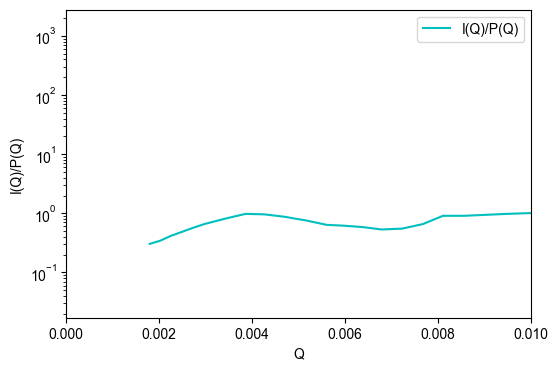

In [17]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
# ax.plot(Q_1,IQ_data_1,'.r')
# ax.plot(Q_1,I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]),'-k')
ax.plot(Q_cat,IQ_cat/I_P_d(Q_cat, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-c',label = 'I(Q)/P(Q)')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([0,0.01])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)/P(Q)')
ax.legend()
plt.show()

### Rescale

In [18]:
## convert the input data to the same 80-D array as SQ-NN model
sq_dim = 80
sample_dim = 1

In [19]:
## rescale the input data Q range
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2

'''
The input data is rescaled to the range such that 0.02<=QD<=16 
'''
r_HS_i = fp_opt_P['sigma']/2 # initial guess of r_HS when Q = 0.04112146, Qr_HS = 3 (first peak)
d_HS_i = r_HS_i*2
print('Initial guess of d_HS = {}'.format(d_HS_i))
IQ_rs = np.zeros((sample_dim,sq_dim)) 
Qd_HS = Q_cat*d_HS_i

## rescale IQ to QD in [0,16]
f_IQ = interp.interp1d(Qd_HS,IQ_cat,fill_value='extrapolate')
IQ_rs = f_IQ(q_rs).astype(np.float32)
IQ_rs[IQ_rs<=0] = 1e-5

## rescale IQ_er to QD in [0,16]
f_IQ_er = interp.interp1d(Qd_HS,IQ_er_cat,fill_value='extrapolate')
IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)
IQ_er_rs[IQ_er_rs<=0] = 1e-5

# ## rescale IQ_er to QD in [0,16]
# f_IQ_er = interp.interp1d(Qd_HS[0:],IQ_er_1[0:],fill_value='extrapolate')
# IQ_er_rs = f_IQ_er(q_rs).astype(np.float32)

Initial guess of d_HS = 1191.9008560746256


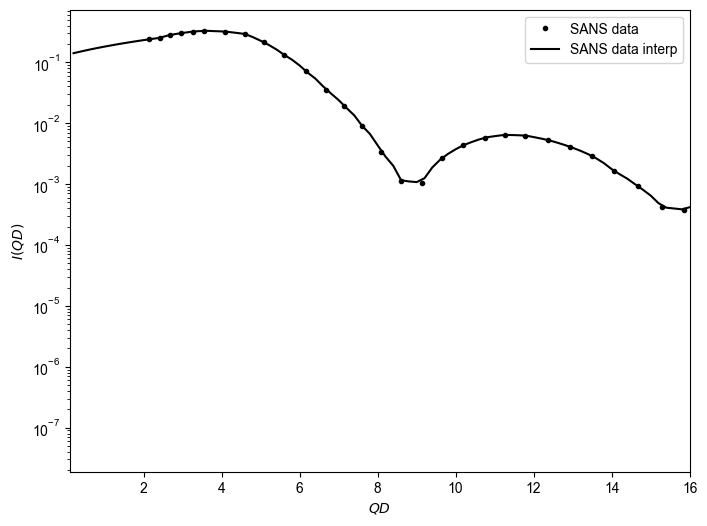

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Qd_HS,IQ_cat,'.k',label='SANS data')
ax.plot(q_rs,IQ_rs,'-k',label='SANS data interp')
ax.set_xlim([0.1,16])
# ax.set_ylim([0.1,30])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

## Define functions 

In [21]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=1)
from RMSA import RMSA
def SQ_RMSA(parameters):
    return(RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2]*np.exp(1/parameters[1]), eta=parameters[0]))

In [36]:
def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_th(sq_func,fp):
    # form factor
    r_sigma = fp[3]
    P = P_HS_eff(q,sigma=r_sigma, d_sigma=fp_opt_P['d_sigma'])

    # structure factor
    # S = SQ_th(sq_func,fp)
    S = savgol_filter(SQ_th(sq_func,fp), 11,2)

    # I(Q)
    IQ = S*P#*fp_opt_I[0] + fp_opt_I[1]

    # # resolution
    # dQ = dQ_sm
    # Q_fine = np.linspace(0.2,16,1000)

    # f_interp = interp.interp1d(q,IQ)
    # IQ_Qfine = f_interp(Q_fine)
    # IQ_res = IQ_resoln(q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(q,IQ,r_sigma) 
    f_interp = interp.interp1d(q,IQ_res_scale)
    # I_scale(QD) = I(QD/fp[3]), 
    # if I_scale(QD) = I^(QD*), D*=D/fp[3], D = D*fp[3]
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp.astype(np.float32)

def IQ_th_res(sq_func,fp):
    # form factor
    r_sigma = fp[3]
    P = P_HS_eff(q,sigma=r_sigma, d_sigma=fp_opt_P[3])

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P#*fp_opt_I[0] + fp_opt_I[1]

    # resolution
    dQ = dQ_sm
    Q_fine = np.linspace(0.2,16,1000)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(q,IQ_res,r_sigma) 
    f_interp = interp.interp1d(q,IQ_res_scale)
    # I_scale(QD) = I(QD/fp[3]), 
    # if I_scale(QD) = I^(QD*), D*=D/fp[3], D = D*fp[3]
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp.astype(np.float32)

## Pick an I(Q) and test

In [37]:
IQ_exp = IQ_rs.astype(np.float32)

### Initial value

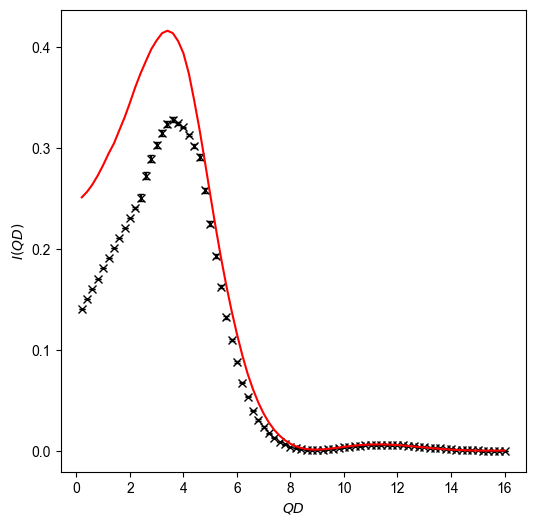

In [48]:
fp_i =       [0.1,  0.17,   2.3,  1]
fp_ubounds = (0.5,  0.5,   20,  1.1)
fp_lbounds = (0.05, 0.05,  0.5, 0.9)
fp_name = ['phi', 'kappa', 'A', 'r_sigma']

params_S = Parameters()
for i in range(3):
    params_S.add(fp_name[i], value=fp_i[i], min=fp_ubounds[i], max=fp_lbounds[i])

# plot initial parameters
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
ax.plot(q,IQ_rs,'xk')
ax.errorbar(q,IQ_rs,IQ_er_rs,color='k',capsize=2,linestyle='')
ax.plot(q,IQ_th(SQ_NN,fp_i),'-r')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

### Fit SQ

In [49]:
index_Q = (q>2)*(q<16)
# loss function for fitting form factor
def lambda_S(params, Q, data, index_Q):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],v['A'],1]
    return (np.log(IQ_th(SQ_NN,fp)) - np.log(data))[index_Q]

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_S, params_S, fcn_args=(q, IQ_rs, index_Q))
result_S = minner.minimize(method='nedler')

# write error report
report_fit(result_S)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 137
    # data points      = 69
    # variables        = 3
    chi-square         = 4.03573463
    reduced chi-square = 0.06114749
    Akaike info crit   = -189.885353
    Bayesian info crit = -183.183033
[[Variables]]
    phi:    0.14535373 +/- 0.00137672 (0.95%) (init = 0.1)
    kappa:  0.15602498 +/- 0.00178928 (1.15%) (init = 0.17)
    A:      2.75758317 +/- 0.05434740 (1.97%) (init = 2.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, A) = +0.5514


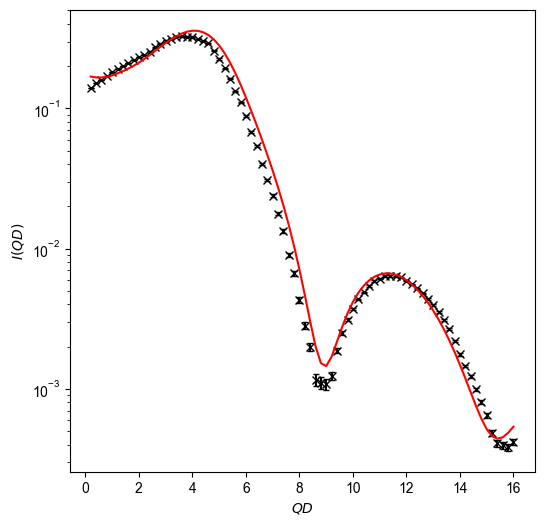

In [50]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

I_inc = 0

fp_opt_NN = result_S.params.valuesdict()
fp_opt_NN_list = [fp_opt_NN['phi'],fp_opt_NN['kappa'],fp_opt_NN['A'],1]

# ax.errorbar(q,IQ_rs,yerr=IQ_er_rs,fmt='k')
ax.plot(q,IQ_rs+I_inc,'xk')
ax.errorbar(q,IQ_rs+I_inc,IQ_er_rs,color='k',capsize=2,linestyle='')
ax.plot(q,IQ_th(SQ_NN_GP,fp_opt_NN_list)+I_inc,'-r')

ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')

# ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

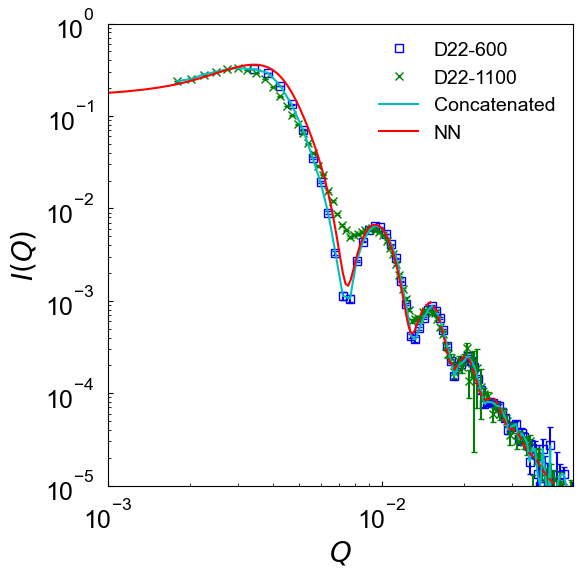

In [51]:
# extend IQ
Q_ext = np.linspace(16,160,145)
IQ_ext = P_HS_eff(Q_ext,sigma=1, d_sigma=fp_opt_P['d_sigma'])

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q_0_d,IQ_0,'sb',label='D22-600', fillstyle='none', ms=6,zorder=-2)
ax.plot(Q_1_d,IQ_1,'xg',label='D22-1100', fillstyle='none', ms=6,zorder=-1)
ax.errorbar(Q_0_d,IQ_0, IQ_er_0_d/fp_opt_I_0['A'], fmt='none', color='b', capsize=2,zorder=-2)
ax.errorbar(Q_1_d,IQ_1, IQ_er_1_d/fp_opt_I_1['A'], fmt='none', color='g', capsize=2,zorder=-1)
ax.plot(Q_cat,IQ_cat,'-c',label='Concatenated')

ax.plot(q/d_HS_i,IQ_th(SQ_NN_GP,fp_opt_NN_list),'-r',label='NN')
ax.plot(Q_ext/d_HS_i,IQ_ext,'--r')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([1e-3,0.05])
ax.set_ylim([1e-5,1])
ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend(fontsize=14, frameon=False)
plt.show()

## Result potential parameters

In [52]:
dataname = str(W)
datapath = './results/'

## Result fitting parameters

In [53]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)  

def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

epsilon_0 = 8.854e-12 # Vacuum_permittivity (F*m^-1 = Columb^2 J^-1)
epsilon_water = 80.4*epsilon_0 #  Water permittivity @ 20 degree C
e = 1.60217663e-19 # Electron charge (Columb)
kB = 1.380649e-23 # Boltzmann constant (J/K)


In [54]:
# fitting parameters
fp_err_NN = np.diag(result_S.covar)
fp = fp_opt_NN_list
fp_err = fp_err_NN
Z_0 = np.sqrt(kB*293*(d_HS_i*1e-9)*epsilon_water/e**2)
fp_Z = Z(fp[2],fp[1])*Z_0
fp_Z_err = Z_err(fp[2],fp[1],fp_err[2],fp_err[1])*Z_0

print('phi =     {:0.4f} +- {:0.4f}'.format(fp[0],fp_err[0]))
print('kappa =   {:0.4f} +- {:0.4f}'.format(fp[1],fp_err[1]))
print('A =       {:0.4f} +- {:0.4f}'.format(fp[2],fp_err[2]))
print('Z =       {:0.4f} +- {:0.4f}'.format(fp_Z,fp_Z_err))

phi =     0.1454 +- 0.0000
kappa =   0.1560 +- 0.0000
A =       2.7576 +- 0.0030
Z =       80.7372 +- 0.0432
